In [39]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc

 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [42]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [43]:
# load questions

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [46]:
# load processed data

import pickle

prefix = ''

with open('TableLlama.3772737819.pickle', 'rb') as handle:
    outlist = pickle.load(handle)
    
len(outlist)

100

### check output against ground truth

In [47]:
# show results

c=0
t=0
h=0

for p in outlist:
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
    # incorrect
    else:
        print(generated_text)
        print(p['output'])
        print('\n')
        # print(prompt)
        # print('\n')

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


Lyman [DESC] unorganized territory [TYPE] unorganized territory>
<Lyman County [DESC] county in South Dakota, United States [TYPE] county of South Dakota>


Sony BMG Music Entertainment [DESC] major record label between 2004–2008; owned by Sony BMG Music Entertainment, Inc. [TYPE] major label>
<Sony Music [DESC] American music company [TYPE] major label>


Alianza Huánuco [DESC] football club [TYPE] association football club>
<Huanuco [DESC] region of Peru [TYPE] region of Peru>


Lipscomb Bisons men's soccer [DESC] American college soccer team [TYPE] association football team>
<Lipscomb Bisons [DESC] sports teams representing Lipscomb University [TYPE] university and college sports club>


CSI: NY, season 6 [DESC] season of television series [TYPE] Television series season>
<CSI: NY [DESC] television series (2004-2013) [TYPE] television series>


1938 New Mexico Lobos football team [DESC] American college football team season [TYPE] American football team season>
<New Mexico Lobos foo

In [48]:
# true, hallucinated, counted
t, h, c

(91, 0, 100)

### sequence components alignment

In [68]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [163]:
checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((idx, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((idx, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((idx, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((idx, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((idx, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((idx, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

In [164]:
# check the checks (must be False)
'False' in checks

False

In [213]:
import pandas as pd
segments = pd.DataFrame(checks, columns = ['pid', 'start', 'end', 'segment'])

In [217]:
# TODO weight section "width" based on averages + cumsum
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})


### collect observables

In [460]:
shapes_pre = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes_pre.append((i,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
        
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes_pre.append((i,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

In [461]:
import pandas as pd
import numpy as np
d = pd.DataFrame(shapes_pre, columns=['pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

In [462]:
# are the max index equal in observables and segments (must be True)
d.groupby('pid').tok.max().sort_values().reset_index(drop=True).equals(segments.groupby('pid').end.max().sort_values().reset_index(drop=True))

True

In [463]:
%%time

# compute section
m = d.merge(segments, on='pid', how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 182 ms, sys: 42.1 ms, total: 224 ms
Wall time: 221 ms


In [464]:
m

,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length
0,0,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40
6,0,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40
12,0,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40
18,0,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40
24,0,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...
2314493,99,3266,generated,1,0.007299,1.000000,3240,3270,generated,5,30
2314499,99,3267,generated,1,1.784877,1.000000,3240,3270,generated,5,30
2314505,99,3268,generated,1,3.481779,1.000000,3240,3270,generated,5,30
2314511,99,3269,generated,1,2.092228,1.000000,3240,3270,generated,5,30


In [465]:
# did we merge all the tokens to their segments (must be True)
d[['pid', 'tok']].sort_values(['pid', 'tok']).reset_index(drop=True).equals(m[['pid', 'tok']].sort_values(['pid', 'tok']).reset_index(drop=True))

True

In [466]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

### token position normalization

In [467]:
segments['length'] = segments.end - segments.start

In [468]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.00,0.000000,40,40,0.010385,0.010385
2,instruction,1,94.00,0.000000,94,94,0.024406,0.034791
1,input,2,2322.48,2026.969438,192,6587,0.603002,0.637793
5,question,3,1306.13,367.519934,119,3814,0.339120,0.976913
3,postilla,4,64.00,0.000000,64,64,0.016617,0.993530
0,generated,5,24.92,6.073090,15,44,0.006470,1.000000


In [469]:
# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end


# normalized per section, offset by section sequence number
# m['tok_rel_segm'] = m.seq + (m.tok / m.end)


# old
# d['tok_rel'] = d.groupby('pid').tok.transform(lambda x: x / x.max())

In [ ]:
# Define background regions [(start, end, color)]
#background_regions = [
#    (0.0, 1.0, palette[0], 'preamble'),
#    (1.0, 2.0, palette[1], 'instruction'),
#    (2.0, 3.0, palette[2], 'input'),
#    (3.0, 4.0, palette[3], 'question'),
#    (4.0, 5.0, palette[4], 'postilla'),
#    (5.0, 6.0, palette[5], 'generated')
#]

In [489]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']
sections = ['preamble', 'instruction', 'table', 'candidates', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

In [492]:
# binning
NUM_BINS = 50

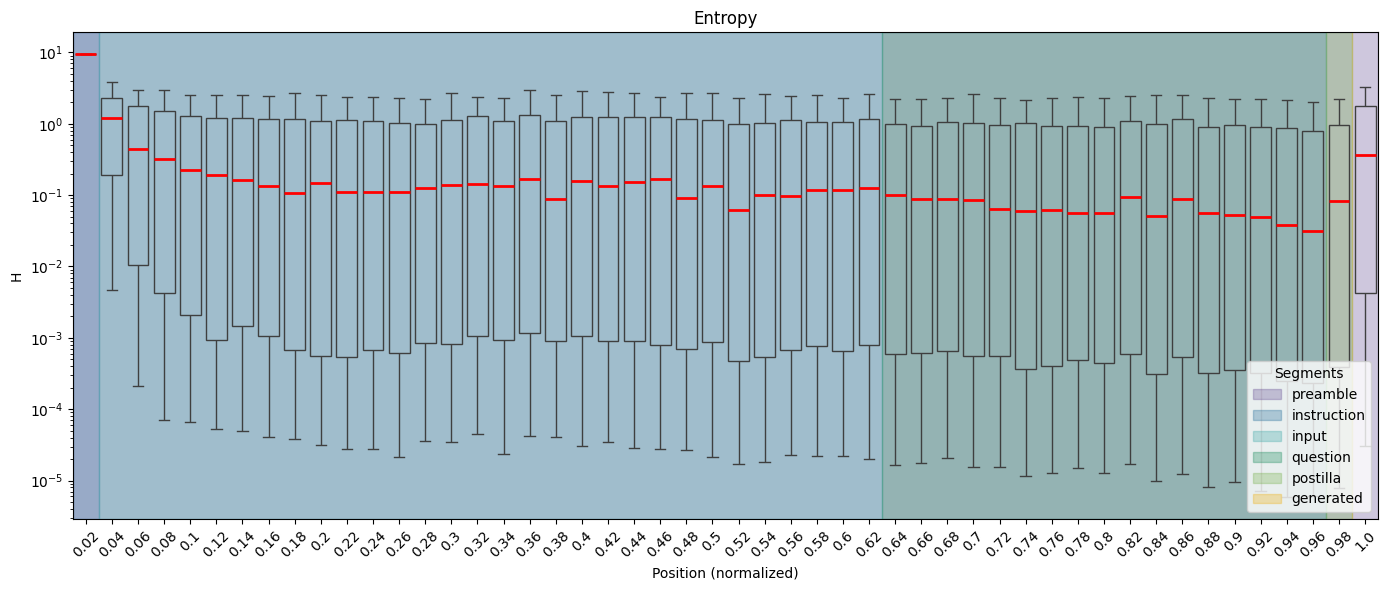

In [499]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

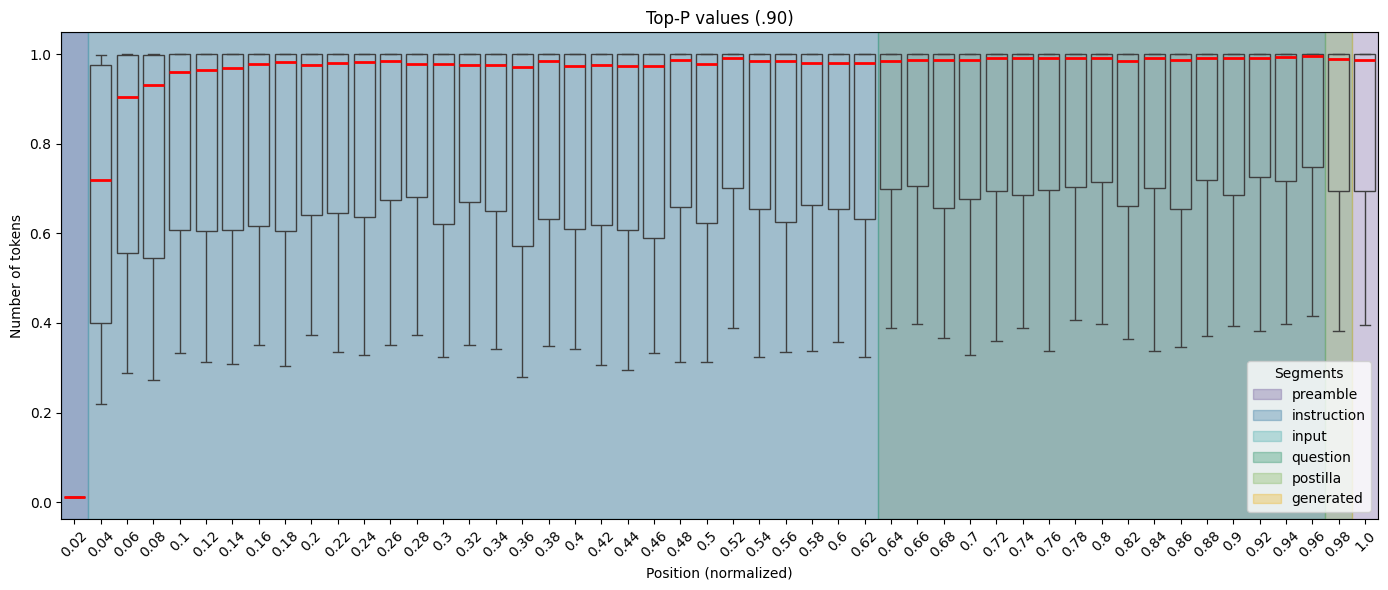

In [498]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("Maximum probability")
plt.title("P")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()